# Purposes of this document

set up tracking linear weights tools

the observation fit a

firing_rates = C x states +  Q

we need to track the weights change in C
as well as how the goodness of the fit using

# ideas

# Experimental setup related to the questions

this part should be configured to directly test the hypothesis put forward in the previous section


In [1]:
from features.simulation_features import get_enc_setup

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'std')

print('examine the encoder weights distribution')
print('We expect the only the first four neurons carry information:')
print(sim_C)

features.simulation_features: get_enc_setup has a tuning_level of 1 

examine the encoder weights distribution
We expect the only the first four neurons carry information:
[[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/blackrock/cerelink.py:13: UserWarning: Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system
  warnings.warn("Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system")


In [2]:
import numpy as np

#encoder mean firing rate
neuron_firing_rates  = [1,10]

#for comparision
exp_conds = [f'enc. mean FR:{b} Hz' for b in neuron_firing_rates]


#setting clda parameters 
##learner: collects paird data at batch_sizes
RHO = 0.5
batch_size = 50


#assistor set up assist level
assist_level = (0.05, 0.0)

#learner and updater: actualy set up rho
UPDATER_BATCH_TIME = 1
UPDATER_HALF_LIFE = np.log(RHO)  * UPDATER_BATCH_TIME / np.log(0.5)


In [3]:
# CHANGE: game mechanics: generate task params
N_TARGETS = 8
N_TRIALS = 80

NUM_EXP = len(exp_conds) # how many experiments we are running. 

# Config the experiments

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

## load dependant libraries

In [4]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom, SimCosineTunedEnc,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow
from riglib.bmi import train

from weights import calc_p_values_for_spike_batches_use_intended_kin
from weights import calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts
import weights

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import itertools #for identical sequences

np.set_printoptions(precision=2, suppress=True)


##  behaviour and task setup

In [5]:
seq = SimBMIControlMulti.sim_target_seq_generator_multi(
N_TARGETS, N_TRIALS)

#create a second version of the tasks
seqs = itertools.tee(seq, NUM_EXP + 1)
target_seq = list(seqs[NUM_EXP])

seqs = seqs[:NUM_EXP]


SAVE_HDF = False
SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist
DEBUG_FEATURE = False


#base_class = SimBMIControlMulti
base_class = BMIControlMultiNoWindow

#for adding experimental features such as encoder, decoder
feats = []

## encoder

the cosine tuned encoder uses a poisson process, right
https://en.wikipedia.org/wiki/Poisson_distribution
so if the lambda is 1, then it's very likely 

In [6]:
ENCODER_TYPE = 'cosine_tuned_encoder'



#actually multiply out the firing rates. 
sim_C_all = [sim_C * nfr for nfr in neuron_firing_rates]


#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)

#set up the encoder
if ENCODER_TYPE == 'cosine_tuned_encoder' :
    feats.append(SimCosineTunedEnc)
    print(f'{__name__}: selected SimCosineTunedEnc\n')

__main__: selected SimCosineTunedEnc



## decoder setup

In [7]:
#clda on random 
DECODER_MODE = 'random' # random 

   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')

__main__: set base class 
__main__: selected SimKFDecoderRandom 



##  clda: learner and updater

In [8]:


LEARNER_TYPE = 'feedback' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'smooth_batch' #none or "smooth_batch"


#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)

#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')
    



## assistor setup

## (Check) config the experiment

In [9]:
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: feats.append(SaveHDF)
if SAVE_SIM_HDF: feats.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)


kwargs_exps = list()

for i in range(NUM_EXP):
    d = dict()
    
    d['assist_level'] = assist_level
    d['sim_C'] = sim_C_all[i]
    d['batch_size'] = batch_size
    
    d['batch_time'] = UPDATER_BATCH_TIME
    d['half_life'] = UPDATER_HALF_LIFE
    
    kwargs_exps.append(d)


kwargs_exps

[{'assist_level': (0.05, 0.0),
  'sim_C': array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
  'batch_size': 50,
  'batch_time': 1,

## make and initalize experiment instances

In [10]:
#seed the experiment
np.random.seed(0)

#spawn the task
Exp = experiment.make(base_class, feats=feats)

exps = list()#create a list of experiment

for i,s in enumerate(seqs):
    e = Exp(s, **kwargs_exps[i])
    exps.append(e)

#run the ini
for e in exps: e.init()

metaclass constructor
(<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>, <class 'bmimultitasks.BMIControlMultiNoWindow'>)
[<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>]

features.simulation_features.SimInte

# Pre-experiment check: check the Kalman filter before training

we replace the encoder using the weights
assume, they are all randomly initialized get the first decoder
get a handle to the first decoder
we check the new decoder C matrix:


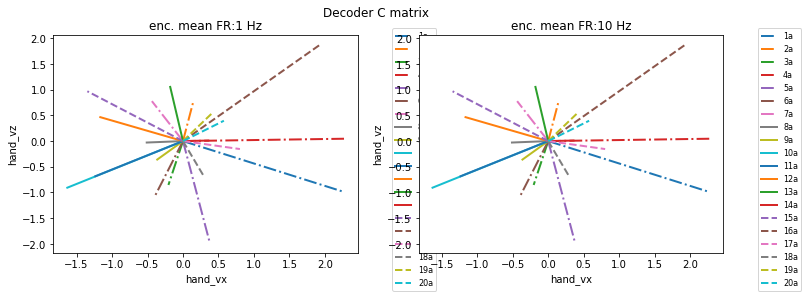

In [11]:
print('we replace the encoder using the weights')
print('assume, they are all randomly initialized get the first decoder')
print('get a handle to the first decoder')
first_decoder = exps[0].decoder
target_C = first_decoder.filt.C
    
#replace the decoder
for i,e in enumerate(exps):
    weights.change_target_kalman_filter_with_a_C_mat(e.decoder.filt, target_C, debug=False)
    
print('we check the new decoder C matrix:')

decoder_c_figure, axs = plt.subplots(nrows=1, 
                               ncols=NUM_EXP, figsize = [12,4])
decoder_c_figure.suptitle('Decoder C matrix ')

for i,e in enumerate(exps):
    e.decoder.plot_C(ax = axs[i])
    axs[i].set_title(exp_conds[i])

# Experiment run: assemble into a complete loop

##  define the function

In [12]:
#make this into a loop

def run_exp_loop(exp,  **kwargs):
        # riglib.experiment: line 597 - 601
    #exp.next_trial = next(exp.gen)
    # -+exp._parse_next_trial()np.arraynp.array


    # we need to set the initial state
    # per fsm.run:  line 138


    # Initialize the FSM before the loop
    exp.set_state(exp.state)
    
    finished_trials = exp.calc_state_occurrences('wait')
    print(f'finished: {finished_trials}')


    while exp.state is not None:

        # exp.fsm_tick()

        ### Execute commands#####
        exp.exec_state_specific_actions(exp.state)

        ###run the bmi loop #####
        # _cycle

        # bmi feature extraction, eh
        #riglib.bmi: 1202
        feature_data = exp.get_features()

        # Determine the target_state and save to file
        current_assist_level = exp.get_current_assist_level()
        target_state = exp.get_target_BMI_state(exp.decoder.states)

        # Determine the assistive control inputs to the Decoder
        #update assistive control level
        exp.update_level()
        if np.any(current_assist_level) > 0:
            current_state = exp.get_current_state()

            if target_state.shape[1] > 1:
                assist_kwargs = exp.assister(current_state, 
                                             target_state[:,0].reshape(-1,1), 
                                             current_assist_level, mode= exp.state)
            else:
                assist_kwargs = exp.assister(current_state, 
                                              target_state, 
                                              current_assist_level, 
                                              mode= exp.state)

            kwargs.update(assist_kwargs)
            
        

        # decode the new features
        # riglib.bmi.bmiloop: line 1245
        neural_features = feature_data[exp.extractor.feature_type]

        # call decoder.
        #tmp = exp.call_decoder(neural_features, target_state, **kwargs)
        neural_obs = neural_features
        learn_flag = exp.learn_flag
        task_state = exp.state

        n_units, n_obs = neural_obs.shape
        # If the target is specified as a 1D position, tile to match
        # the number of dimensions as the neural features
        if np.ndim(target_state) == 1 or (target_state.shape[1] == 1 and n_obs > 1):
            target_state = np.tile(target_state, [1, n_obs])

        decoded_states = np.zeros([exp.bmi_system.decoder.n_states, n_obs])
        update_flag = False

        for k in range(n_obs):
            neural_obs_k = neural_obs[:, k].reshape(-1, 1)
            target_state_k = target_state[:, k]

            # NOTE: the conditional below is *only* for compatibility with older Carmena
            # lab data collected using a different MATLAB-based system. In all python cases,
            # the task_state should never contain NaN values.
            if np.any(np.isnan(target_state_k)):
                task_state = 'no_target'

            #################################
            # Decode the current observation
            #################################
            decodable_obs, decode = exp.bmi_system.feature_accumulator(
                neural_obs_k)
            if decode:  # if a new decodable observation is available from the feature accumulator
                prev_state = exp.bmi_system.decoder.get_state()

                exp.bmi_system.decoder(decodable_obs, **kwargs)
                # Determine whether the current state or previous state should be given to the learner
                if exp.bmi_system.learner.input_state_index == 0:
                    learner_state = exp.bmi_system.decoder.get_state()
                elif exp.bmi_system.learner.input_state_index == -1:
                    learner_state = prev_state
                else:
                    print(("Not implemented yet: %d" %
                           exp.bmi_system.learner.input_state_index))
                    learner_state = prev_state

                if learn_flag:
                    exp.bmi_system.learner(decodable_obs.copy(), learner_state, target_state_k, exp.bmi_system.decoder.get_state(
                    ), task_state, state_order=exp.bmi_system.decoder.ssm.state_order)

            decoded_states[:, k] = exp.bmi_system.decoder.get_state()

            ############################
            # Update decoder parameters
            ############################
            if exp.bmi_system.learner.is_ready():
                batch_data = exp.bmi_system.learner.get_batch()
                batch_data['decoder'] = exp.bmi_system.decoder
                kwargs.update(batch_data)
                exp.bmi_system.updater(**kwargs)
                exp.bmi_system.learner.disable()

            new_params = None  # by default, no new parameters are available
            if exp.bmi_system.has_updater:
                new_params = copy.deepcopy(exp.bmi_system.updater.get_result())

            # Update the decoder if new parameters are available
            if not (new_params is None):
                exp.bmi_system.decoder.update_params(
                    new_params, **exp.bmi_system.updater.update_kwargs)
                new_params['intended_kin'] = batch_data['intended_kin']
                new_params['spike_counts_batch'] = batch_data['spike_counts']

                exp.bmi_system.learner.enable()
                update_flag = True

                # Save new parameters to parameter history
                exp.bmi_system.param_hist.append(new_params)



        # saved as task data
        # return decoded_states, update_flag
        tmp = decoded_states
        exp.task_data['internal_decoder_state'] = tmp

        # reset the plant position
        # @riglib.bmi.BMILoop.move_plant  line:1254
        exp.plant.drive(exp.decoder)

        # check state transitions and run the FSM.
        current_state = exp.state

        # iterate over the possible events which could move the task out of the current state
        for event in exp.status[current_state]:
            # if the event has occurred
            if exp.test_state_transition_event(event):
                # execute commands to end the current state
                exp.end_state(current_state)

                # trigger the transition for the event
                exp.trigger_event(event)

                # stop searching for transition events (transition events must be
                # mutually exclusive for this FSM to function properly)
                break

        # sort out the loop params.
        # inc cycle count
        exp.cycle_count += 1

        # save target data as was done in manualControlTasks._cycle
        exp.task_data['target'] = exp.target_location.copy()
        exp.task_data['target_index'] = exp.target_index

        #done in bmi:_cycle after move_plant
        exp.task_data['loop_time'] = exp.iter_time()


        #fb_controller data
        exp.task_data['target_state'] = target_state

        #encoder data
        #input to this is actually extractor
        exp.task_data['ctrl_input'] = np.reshape(exp.extractor.sim_ctrl, (1,-1))

        #actually output
        exp.task_data['spike_counts'] = feature_data['spike_counts']


        #save the decoder_state
        #from BMILoop.move_plant
        exp.task_data['decoder_state'] = exp.decoder.get_state(shape=(-1,1))
        
        #save bmi_data
        exp.task_data['update_bmi'] = update_flag


        # as well as plant data.
        plant_data = exp.plant.get_data_to_save()
        for key in plant_data:
            exp.task_data[key] = plant_data[key]

        # clda data handled in the above call.

        # save to the list hisory of data.
        exp.task_data_hist.append(exp.task_data.copy())
        
        #print out the trial update whenever wait count changes, alright. 
        if finished_trials != exp.calc_state_occurrences('wait'):
            finished_trials = exp.calc_state_occurrences('wait')
            print(f'finished trials :{finished_trials} with a current assist level of {exp.get_current_assist_level()}')


    if exp.verbose:
        print("end of FSM.run, task state is", exp.state)
    
    


## actually running the experiments

In [13]:
for i,e in enumerate(exps):
    run_exp_loop(e, **kwargs_exps[i])
    print(f'Finished running  {exp_conds[i]}')

runseq
finished: 1
assist_level:  0.05


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:372: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


assist_level:  0.045
finished trials :2 with a current assist level of 0.04423333333333333
finished trials :3 with a current assist level of 0.04369166666666667
finished trials :4 with a current assist level of 0.04235833333333333
finished trials :5 with a current assist level of 0.041925000000000004
finished trials :6 with a current assist level of 0.04166666666666667
finished trials :7 with a current assist level of 0.04058333333333333
finished trials :8 with a current assist level of 0.04000694444444444
assist_level:  0.04
finished trials :9 with a current assist level of 0.0395
finished trials :10 with a current assist level of 0.038997222222222225
finished trials :11 with a current assist level of 0.03734166666666667
finished trials :12 with a current assist level of 0.03680833333333333
finished trials :13 with a current assist level of 0.03621666666666667
finished trials :14 with a current assist level of 0.03536527777777778
assist_level:  0.035
finished trials :15 with a current

finished trials :36 with a current assist level of 0.03838333333333334
finished trials :37 with a current assist level of 0.03814166666666667
finished trials :38 with a current assist level of 0.03782361111111111
finished trials :39 with a current assist level of 0.03759166666666667
finished trials :40 with a current assist level of 0.03736527777777778
finished trials :41 with a current assist level of 0.03714861111111111
finished trials :42 with a current assist level of 0.03691388888888889
finished trials :43 with a current assist level of 0.03670555555555556
finished trials :44 with a current assist level of 0.03648194444444445
finished trials :45 with a current assist level of 0.03621666666666667
finished trials :46 with a current assist level of 0.03595555555555556
finished trials :47 with a current assist level of 0.03565694444444445
finished trials :48 with a current assist level of 0.035023611111111116
finished trials :49 with a current assist level of 0.034758333333333336
fini

# Postprocessing the data for loading

In [14]:
for e in  exps: print(e.calc_state_occurrences('reward'))

80
80


## declare defs and conventions

In [15]:
FRAME_RATE = 60
INT_WINDOW_TIME = 10 # s for looking at sample raw data

# some conventions as we go down the loop
X_VEL_STATE_IND = 3
Y_VEL_STATE_IND = 5
X_POS_STATE_IND = 0
Y_POS_STATE_IND = 2

state_indices = [X_POS_STATE_IND,
                 Y_POS_STATE_IND,
                 X_VEL_STATE_IND,
                 Y_VEL_STATE_IND]
state_names = ['x pos ', 'y pos', 'x vel', 'y vel']


INT_WIN_SAMPLES = INT_WINDOW_TIME * FRAME_RATE



## Refactor out the data

In [16]:
task_data_hist_np_all = [np.array(e.task_data_hist) for e in exps]
len(task_data_hist_np_all)
task_data_hist_np_all[0].dtype

dtype([('cursor', '<f8', (3,)), ('obs_t', '<f8', (20, 1)), ('K', '<f8', (7, 20)), ('KC', '<f8', (7, 7)), ('pred_state_mean', '<f8', (7, 1)), ('post_state_mean', '<f8', (7, 1)), ('pred_state_P', '<f8', (7, 7)), ('post_state_P', '<f8', (7, 7)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (20, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

## Finished time in seconds

In [17]:
finished_times_in_seconds = [int(len(s)/FRAME_RATE) for s in task_data_hist_np_all]
finished_times_in_seconds

[788, 290]

# Post data analysis

## Overall  trial statistics succuss rate)

In [18]:
def filter_state(state_log:list, state_to_match:str)->list:
    '''#set axis limits of plot (x=0 to 20, y=0 to 20)
plt.axis([0, 20, 0, 20])
plt.axis("equal")

    state_log: a list of tuples (state:string, start_time: float)
    state_to_watch
    
    returns a list of element type
    '''
    
    return list(filter(lambda k: k[0] == state_to_match, state_log) )

def calc_inter_wait_times(wait_log: list)-> list:
    """
    state_log: a list of tuples ("wait", start_time: float)
    return a list of tuples: ("wait", start_time: float, diff_time)
    """
    wait_log_with_diff = list()
    for i, wait_state in enumerate(wait_log):
        if i == len(wait_log)-1: #there is nothing to subtract, just put zero.
            wait_log_with_diff.append((wait_state[1],  0))
            
        else:
            finish_time = wait_log[i+1][1]
            wait_log_with_diff.append((wait_state[1],  finish_time - wait_state[1]))
    
    return np.array(wait_log_with_diff[:-1])

In [19]:
state_logs = [e.state_log for e in exps]


In [20]:
STATE_CUT_NAME =  'wait'
#get the state logs
wait_logs = [filter_state(s, STATE_CUT_NAME) for s in state_logs]

inter_wait_times = [calc_inter_wait_times(w) for w in wait_logs]
#this has both start times 

Text(0, 0.5, 'Trial time (s)')

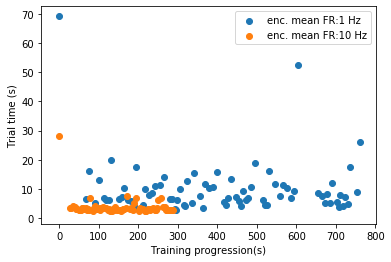

In [21]:


for i in inter_wait_times:
    plt.scatter(i[:,0], i[:,1])

plt.legend(exp_conds)
plt.xlabel('Training progression(s)')
plt.ylabel('Trial time (s)')

In [22]:
wait_time = inter_wait_times[0]
task_data_hist_np = task_data_hist_np_all[0]



In [23]:
def sort_trials(wait_time:list, 
                target_seq:list,
                task_data_hist_np:dict, 
                dict_keys, FRAME_RATE = 60):
    trial_dict = list()
    
    for i,row in enumerate(wait_time):
        start_time = row[0]
        inter_wait_time = row[1]

        start_sample = int(start_time * FRAME_RATE)
        inter_wait_sample = int(inter_wait_time * FRAME_RATE)
        stop_sample = start_sample + inter_wait_sample

        single_trial_dict = dict()

        for k in dict_keys:
            
            requested_type_data = np.squeeze(task_data_hist_np[k])
            single_trial_dict[k] =  requested_type_data[start_sample:stop_sample,
                                                       :]
        #add more info
        single_trial_dict['start_time'] = row[0]
        single_trial_dict['inter_wait_time'] = row[1]
        
        #add target info
        single_trial_dict['targets'] = target_seq[i]

        #add the dictionary to the list
        trial_dict.append(single_trial_dict)
        
    return trial_dict



In [24]:


trial_dicts_all = []
dict_keys = ['cursor', #behaviour
             'ctrl_input', 'spike_counts', #encoder translates intended ctrl into spike counts
             'decoder_state']

for i in range(NUM_EXP):
    wait_time = inter_wait_times[i]
    task_data_hist_np = task_data_hist_np_all[i]
    
    trial_dict_0 = sort_trials(wait_time, 
                               target_seq,
                               task_data_hist_np, dict_keys)
    
    trial_dicts_all.append(trial_dict_0)

len(trial_dicts_all)

2

## Trajectory analysis

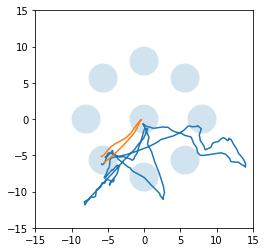

In [25]:
n_roi_trials = N_TRIALS - 1
unique_targets =  np.unique(target_seq, axis = 0)


X_CURSOR = 0
Z_CURSOR = 2
CIRCL_ALPHA = 0.2



RANGE_LIM =  15
figure, axes = plt.subplots() 

axes.set_xlim(-RANGE_LIM, RANGE_LIM)
axes.set_ylim(-RANGE_LIM, RANGE_LIM)

CIRCLE_RADIUS = exps[0].target_radius

#plot the targets

#plot the origin

cc = plt.Circle((0,0 ), 
            radius = CIRCLE_RADIUS,
            alpha = CIRCL_ALPHA)

axes.add_artist( cc ) 

for origin_t in unique_targets:
    origin = origin_t[0]
    t = origin_t[1]

    cc = plt.Circle((t[X_CURSOR],t[Z_CURSOR] ), 
                    radius = CIRCLE_RADIUS,
                    alpha = CIRCL_ALPHA)
                     
    axes.set_aspect( 1 ) 
    axes.add_artist( cc ) 
    
    
for trial_dict in trial_dicts_all:
    
    sample_trial = trial_dict[n_roi_trials]
    trial_cursor_trajectory = sample_trial['cursor']
    
    
    axes.plot(trial_cursor_trajectory[:, X_CURSOR], 
             trial_cursor_trajectory[:, Z_CURSOR])



In [26]:
print('finished trials:')

for i,e in  enumerate(exps): 
    reward_num = e.calc_state_occurrences('reward')
    print(f'{exp_conds[i]}: {reward_num} out of {N_TRIALS}')

finished trials:
enc. mean FR:1 Hz: 80 out of 80
enc. mean FR:10 Hz: 80 out of 80


## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

In [27]:
print('the encoder observation Q matrix')
for i,e in enumerate(exps):
    print(exp_conds[i])
    print(e.encoder.ssm.w)

the encoder observation Q matrix
enc. mean FR:1 Hz
7
enc. mean FR:10 Hz
7


In [28]:
n_exp = 0


spike_count_sample = trial_dicts_all[n_exp][n_roi_trials]['spike_counts']

## decoder

steady state tuning curves:


Text(0, -0.27999999999999997, 'CLDA rho 0.5')

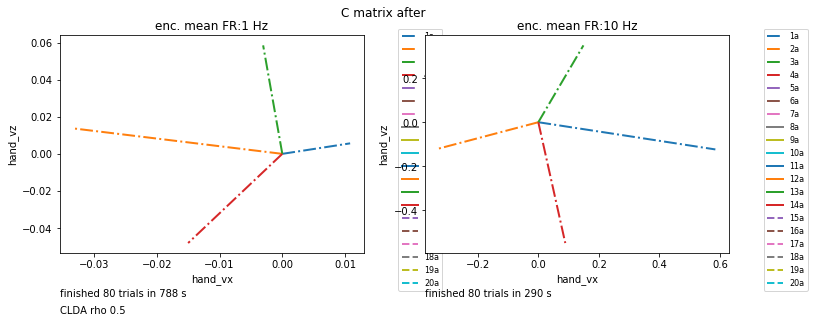

In [29]:
TEXT_OFFSET_VERTICAL = -0.2

decoder_c_after,axs = plt.subplots(1, NUM_EXP,
                                  figsize = (12,4))

decoder_c_after.suptitle('C matrix after')

print('steady state tuning curves:')
for i,e in enumerate(exps):
    e.decoder.plot_C(ax = axs[i])
    axs[i].set_title(exp_conds[i])
    
    #get the lower left coordinate
    y_lim_range  = axs[i].get_ylim()[1] - axs[i].get_ylim()[0]
    
    axs[i].text(0, TEXT_OFFSET_VERTICAL,
                f'finished {N_TRIALS} trials in {finished_times_in_seconds[i]} s', 
               transform = axs[i].transAxes)

decoder_c_after.text(0, 1.4 * TEXT_OFFSET_VERTICAL, 
                     f'CLDA rho {RHO}',
                    transform = axs[0].transAxes)


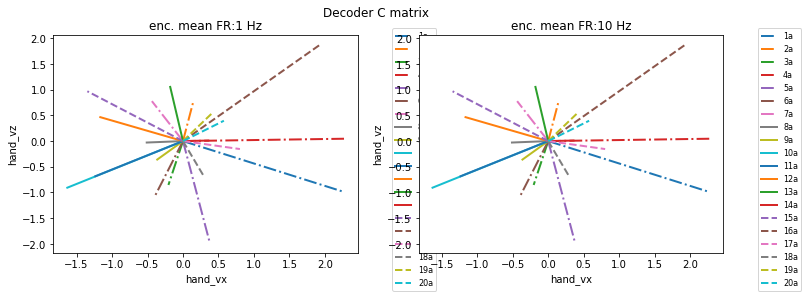

In [30]:
decoder_c_figure

## compare before and after the training

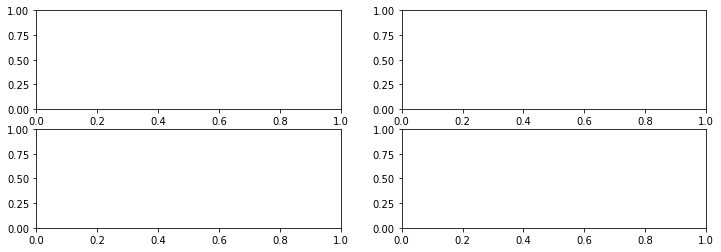

In [31]:


N_ROWS = 2 #before and after 
FIGURE_SIZE_2_by_4 = (12,4)
figure_compare_decoder_C_matrix,axs = plt.subplots(2,NUM_EXP, 
                                                   figsize = (12,4))

for i in range(NUM_EXP):
    axs[0, i] = decoder_c_figure.get_axes()[i]
    axs[1, i] = decoder_c_after.get_axes()[i]
    

# CLDA updates

## clda update frequencies

In [32]:

clda_params_all = [np.array(e.bmi_system.param_hist) for e in exps]

for c in clda_params_all:
    print(f'did clda for {len(c)} times')

did clda for 157 times
did clda for 58 times


In [33]:
update_bmi_all = np.squeeze(task_data_hist_np_all[0]['update_bmi'])

Text(0.5, 0, 'frame count')

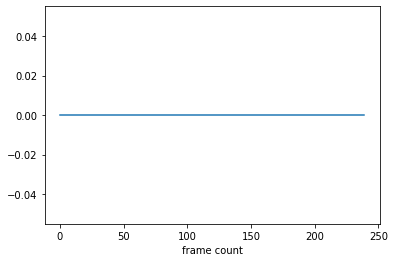

In [34]:
plt.plot(update_bmi_all[:240])
plt.xlabel('frame count')

## reformat the matrix

In [35]:
clda_params = clda_params_all[1]

clda_params_dict_all = list()

for p in clda_params_all:
    clda_params_dict = dict()
    for param_key in p[0].keys():
        clda_params_dict[param_key] = np.array([ record_i[param_key] for record_i in p])
    
    clda_params_dict_all.append(clda_params_dict)


len(clda_params_dict_all)

2

## observation covariance matrix

In [36]:
n_sample = 1

for i,c in enumerate(clda_params_dict_all):
    print(exp_conds[i])
    print(c['kf.Q'][n_sample,:,:])
    print()

enc. mean FR:1 Hz
[[2.95 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   2.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   2.53 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   2.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   2.5  0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   2.5  0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   2.5  0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   2.5  0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   2.5  0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   2.5  0. 

## clda K matrix

In [37]:
kf_C = clda_params_dict['kf.C']

In [38]:
print('K matrix before:')
print(kf_C[0,:,:])
print('K matrix after:')
print(kf_C[-1,:,:])

K matrix before:
[[ 0.    0.    0.    1.68  0.   -0.59  0.49]
 [ 0.    0.    0.    0.07  0.    0.38  0.06]
 [ 0.    0.    0.   -0.09  0.    0.06 -1.26]
 [ 0.    0.    0.    1.15  0.   -0.04 -0.09]
 [ 0.    0.    0.    0.19  0.   -0.99 -0.17]
 [ 0.    0.    0.   -0.19  0.   -0.52 -0.71]
 [ 0.    0.    0.   -0.22  0.    0.39 -0.81]
 [ 0.    0.    0.   -0.26  0.   -0.01  0.21]
 [ 0.    0.    0.   -0.18  0.   -0.18 -0.41]
 [ 0.    0.    0.   -0.82  0.   -0.45  0.03]
 [ 0.    0.    0.   -0.62  0.   -0.34 -0.44]
 [ 0.    0.    0.   -0.58  0.    0.23 -0.77]
 [ 0.    0.    0.   -0.09  0.    0.53 -0.2 ]
 [ 0.    0.    0.    0.18  0.    0.01  0.89]
 [ 0.    0.    0.   -0.67  0.    0.48 -0.59]
 [ 0.    0.    0.    0.96  0.    0.93  0.45]
 [ 0.    0.    0.    0.4   0.   -0.08  0.31]
 [ 0.    0.    0.    0.15  0.   -0.35 -0.07]
 [ 0.    0.    0.    0.2   0.    0.27 -0.34]
 [ 0.    0.    0.    0.29  0.    0.2  -0.55]]
K matrix after:
[[ 0.    0.    0.    0.58  0.   -0.12  2.04]
 [ 0.    0.    0.   -

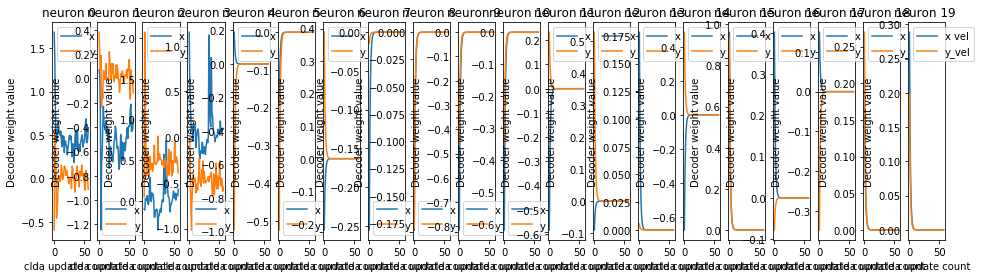

In [39]:
N_CLDA_ROI_TIME = 800

FIGURE_SIZE = (2,10)

N_NEURONS

f, axs = plt.subplots(1,N_NEURONS,figsize=(16,4))

for i in range(N_NEURONS):
    axs[i].plot(np.squeeze(kf_C[:N_CLDA_ROI_TIME,i, X_VEL_STATE_IND]))
    axs[i].plot(np.squeeze(kf_C[:N_CLDA_ROI_TIME,i, Y_VEL_STATE_IND]))
    axs[i].legend(['x vel', 'y_vel'])
    axs[i].set_title(f'neuron {i} ')
    axs[i].set_xlabel('clda update count ')
    axs[i].set_ylabel('Decoder weight value')



In [40]:
exps[0].encoder.C

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## examine training batches

In [41]:
spike_counts_batch = clda_params_dict['spike_counts_batch'] 
intended_kin = clda_params_dict['intended_kin']

In [42]:
training_sample_point = 2

print('intended kinematics:')
print(intended_kin[training_sample_point])

print('spike counts:')
print(spike_counts_batch[training_sample_point])

print('trained KF C matrix:')
print(kf_C[training_sample_point])

intended kinematics:
[[ 5.55  5.57  5.68  5.75  5.81  5.88  5.97  6.05  6.17  6.2   6.27  6.32
   6.37  6.49  6.48  6.42  6.37  6.31  6.27  6.24  6.21  6.16  6.1   6.13
   6.1   6.07  6.05  6.02  6.05  6.    6.    6.    6.    5.98  5.98  6.01
   6.01  6.06  6.04  6.04  6.07  6.1   6.13  6.18  6.21  6.27  6.29  6.32
   6.33  6.36]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [-1.76 -1.47 -1.22 -0.94 -0.63 -0.43 -0.3  -0.15 -0.02  0.2   0.38  0.52
   0.62  0.73  0.84  0.96  1.08  1.2   1.34  1.46  1.57  1.68  1.78  1.9
   2.    2.11  2.24  2.35  2.45  2.57  2.68  2.78  2.88  2.99  3.09  3.19
   3.28  3.38  3.47  3.56  3.67  3.76  3.86  3.95  4.03  4.12  4.21  4.31
   4.41  4.5 ]
 [ 2.12  2.1   2.48  2.28  2.16  2.11  2.15  2.05  2.14

# Measure weights change

In [43]:
from weights_linear_regression import *
from afs_plotting import plot_prefered_directions

In [44]:
kf_C = clda_params_dict['kf.C']
kf_C.shape

(58, 20, 7)

In [45]:
history_of_L2_norms = calc_a_history_of_matrix_L2norms_along_first_axis(kf_C,
                                                                       (X_VEL_STATE_IND, Y_VEL_STATE_IND))

history_of_L2_norms.shape

(58, 20)

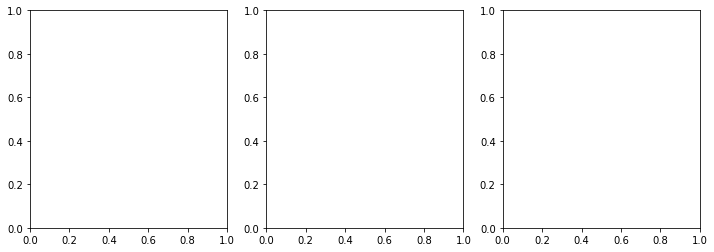

In [46]:
figure_compare_kf, axes_compare_kf = plt.subplots(1,3, figsize = (12, 4))

kf_slice has kf_slice has shape (20, 7)


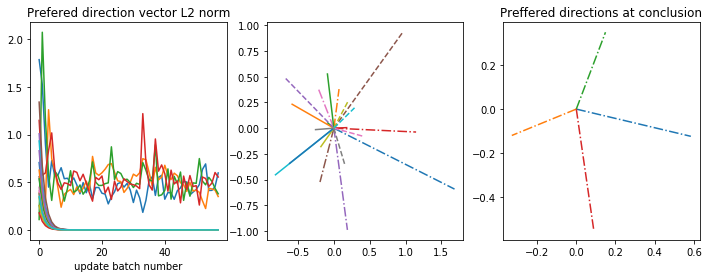

In [49]:
time_of_interest = 0
kf_slice_start = np.squeeze(kf_C[time_of_interest, :,:])
print(f'kf_slice has kf_slice has shape {kf_slice_start.shape}')

kf_slice_end = np.squeeze(kf_C[-1, :,:])


#plot the trajectjory
axes_compare_kf[0].plot(history_of_L2_norms)

#plot the begining 
plot_prefered_directions(kf_slice_start, 
                         ax = axes_compare_kf[1])
axes_compare_kf[0].set_title('Prefered direction vector L2 norm')
axes_compare_kf[0].set_xlabel('update batch number')



#plot the end
plot_prefered_directions(kf_slice_end, 
                         ax = axes_compare_kf[2])
axes_compare_kf[2].set_title('Preffered directions at conclusion')


figure_compare_kf

# Measure ssms

In [50]:
spike_counts_batch = clda_params_dict['spike_counts_batch'] 
intended_kin = clda_params_dict['intended_kin']

print(f'spike_counts_batch has the shape of {spike_counts_batch.shape}')
print(f'intended_kin has the shape of {intended_kin.shape}')

print(f'kf_C has the shape of {kf_C.shape}')


spike_counts_batch has the shape of (58, 20, 50)
intended_kin has the shape of (58, 7, 50)
kf_C has the shape of (58, 20, 7)


In [88]:
VEL_DECODING_STATES = (X_VEL_STATE_IND, Y_VEL_STATE_IND,)
print(f'we will only be looking the indices of the x vel and y vel {VEL_DECODING_STATES}')

time_slice_of_interest = 0
print(f'time slice of interest {time_slice_of_interest}')

spike_count_slice = np.squeeze(spike_counts_batch[time_slice_of_interest, :, :])
intended_kin_slice = np.squeeze(intended_kin[time_slice_of_interest, VEL_DECODING_STATES, :])
kf_C_slice = np.squeeze(kf_C[time_slice_of_interest, :,VEL_DECODING_STATES])

#rotate the dimensions=
spike_count_slice = spike_count_slice.T
intended_kin_slice = intended_kin_slice.T
kf_C_slice = kf_C_slice.T


print(f'spike_count_slice has the shape of {spike_count_slice.shape}')
print(f'intended_kin_slice has the shape of {intended_kin_slice.shape}')

print(f'kf_C_slice has the shape of {kf_C_slice.shape}')

we will only be looking the indices of the x vel and y vel (3, 5)
time slice of interest 0
spike_count_slice has the shape of (50, 20)
intended_kin_slice has the shape of (50, 2)
kf_C_slice has the shape of (20, 2)


In [89]:
from weights_linear_regression import calc_average_ssm_for_each_X_column

ssm_slice = calc_average_ssm_for_each_X_column(intended_kin_slice, spike_count_slice, kf_C_slice)

ssm_slice.shape

(20,)

## encapsulate into the batch

In [91]:
(N_BATCHES, N_NEURONS, N_POINTS_IN_A_BATCH)  =  spike_counts_batch.shape

#initialize an nan array
ssm_all_batches = np.empty((N_BATCHES, N_NEURONS))
ssm_all_batches[:] = np.nan

for n_batch in range(N_BATCHES):
    spike_count_slice = np.squeeze(spike_counts_batch[n_batch, :, :])
    intended_kin_slice = np.squeeze(intended_kin[n_batch, VEL_DECODING_STATES, :])
    kf_C_slice = np.squeeze(kf_C[n_batch,:,VEL_DECODING_STATES])
    
    #rotate the dimensions=
    spike_count_slice = spike_count_slice.T
    intended_kin_slice = intended_kin_slice.T
    kf_C_slice = kf_C_slice.T

    
    ssm_slice = calc_average_ssm_for_each_X_column(intended_kin_slice, 
                                                   spike_count_slice, 
                                                   kf_C_slice)
    ssm_all_batches[n_batch, :] = ssm_slice
    
    


look at these two neurons range(0, 8)


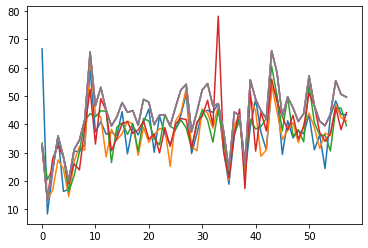

In [92]:
neurons_of_interest = range(8)

print(f'look at these two neurons {neurons_of_interest}')

plt.plot(ssm_all_batches[:, neurons_of_interest])

## over all ssm

In [94]:
(N_BATCHES, N_NEURONS, N_POINTS_IN_A_BATCH)  =  spike_counts_batch.shape

#initialize an nan array
ssm_all_batches = np.empty((N_BATCHES,))


for n_batch in range(N_BATCHES):
    spike_count_slice = np.squeeze(spike_counts_batch[n_batch, :, :])
    intended_kin_slice = np.squeeze(intended_kin[n_batch, VEL_DECODING_STATES, :])
    kf_C_slice = np.squeeze(kf_C[n_batch, :,VEL_DECODING_STATES])
    
    #rotate the dimensions=
    spike_count_slice = spike_count_slice.T
    intended_kin_slice = intended_kin_slice.T
    kf_C_slice = kf_C_slice.T
    
    ssm_slice = calc_ssm_y_minus_x_beta(intended_kin_slice, 
                                                   spike_count_slice, 
                                                   kf_C_slice)
    ssm_all_batches[n_batch] = ssm_slice
    
ssm_all_batches = ssm_all_batches / N_POINTS_IN_A_BATCH
    

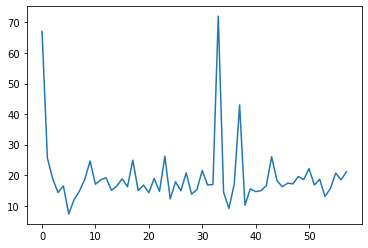

In [95]:
plt.plot(ssm_all_batches)
plt.set_xlabel()

# feature analyses hypothesis testing

In [ ]:
import statsmodels.api as sm


## Examine relevance of one neuron from one batch 

### Select data

In [ ]:
clda_params_dict.keys() # this is from one experiment

In [ ]:
spike_counts_batch = clda_params_dict['spike_counts_batch']
intended_kin = clda_params_dict['intended_kin']
print(f'{len(spike_counts_batch)}')
print(f'{len(intended_kin)}')

In [ ]:
# we just take one batch
batch_of_interest = 0
spike_count_one_batch = spike_counts_batch[batch_of_interest]
intended_kin_one_batch = intended_kin[batch_of_interest]

print(f'look at one batch: batch number {batch_of_interest}')
print(f'spike count')
print(spike_count_one_batch)

print(f'intended kin')
print(intended_kin_one_batch)

In [ ]:
print('we are dealing with a velocity decoder')
print('we only look at  x vel and y vel:')
print('We assume we are only interested how firing rates encode x, y vel')

intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
print('after selecting the vels:')
print(intended_kin_one_batch_2D)

In [ ]:
print('we will do  one neuron at a time')
n_roi_neuron = 0
print(f'the neuron that we are interested is neuron {n_roi_neuron}')
print('and selected firing rates:')

spike_count_one_batch_one_neuron = spike_count_one_batch[n_roi_neuron,:]

print(spike_count_one_batch_one_neuron)

### OLS model fitting

In [ ]:
print('we transpose the vector for fitting')
X = intended_kin_one_batch_2D.T
y = np.reshape(spike_count_one_batch_one_neuron, (-1,1))


print('the independent variables are  the intended kin hence, X')
print(X)


print('the dependent variable is the neuron spike connt, hence y')
print(y)


In [ ]:
print('we add the constant one to the states (X)')
X = sm.add_constant(X, has_constant= 'raise')
print('the new X is')
print(X)

In [ ]:
print('now we can fit using statsmodels.ols')

ols_spike_from_states = sm.OLS(y, X)

results_ols_spike_from_states = ols_spike_from_states.fit()

print('print results')
print(results_ols_spike_from_states.summary())

In [ ]:
print('the p-values test against if the coefficients are zero')
neuron_batch_pvalue = results_ols_spike_from_states.pvalues

print(f'the p values for this neuron of index {n_roi_neuron}')
print(neuron_batch_pvalue)

neuron_batch_coeff = results_ols_spike_from_states.params

print('the reg. coeff. are ')
print(neuron_batch_coeff)

print()
significance_level = 0.05
print(f'at a significance_level of {significance_level}:')
print('this array has the indix of the states that are significantly correlated with the firing rates  ')

np.where(neuron_batch_pvalue < significance_level)

## iterate up the model testing procedure

In [ ]:
print('we write a function that actually  check if any given neuron has a sig state')



        






In [ ]:
print('with the functions, we can fit and test the one neuron and against the state')

In [ ]:
significance_level = 0.05


    




In [ ]:
from weights import fit_ols

print('we transpose the vector for fitting')
X = intended_kin_one_batch_2D.T
y = np.reshape(spike_count_one_batch_one_neuron, (-1,1))


print('the independent variables are  the intended kin hence, X')
print(X)


print('the dependent variable is the neuron spike connt, hence y')
print(y)

results = fit_ols(y, X)

print('fitting_results:')
print(results)


## test across the neurons in a batch

In [ ]:
spike_count_one_batch.shape

In [ ]:


n_roi_neuron = 0

#assume spike_count_one_batch has the shape N_NEURONS by N_time points
#assume that intended_kin_one_batch_2D has N_states by N_Time_points

'''

'''
#get intended kinematics this is fixed for each neuron
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
#('we transpose the vector for fitting')
intended_kin_one_batch_2D = intended_kin_one_batch_2D.T
spike_count_one_batch = intended_kin_one_batch.T

neuron_batch_pvalue_matrix = calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts(spike_count_one_batch,
                                                                       intended_kin_one_batch_2D)

print(f'the pvalue matrix for a batch')
neuron_batch_pvalue_matrix

In [ ]:


print('test out the calculate_p_value_matrix')

calc_p_value_matrix_result = calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts(
                            intended_kin_one_batch_2D, 
                            spike_count_one_batch)
print(calc_p_value_matrix_result)
print()
print('for comparision, this is what we just calculated')
neuron_batch_pvalue_matrix

## calculate p_values for a different batch

In [ ]:
# we just take one batch
batch_of_interest = 1

intended_kin_one_batch = intended_kin[batch_of_interest]
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
spike_count_one_batch = spike_counts_batch[batch_of_interest]

print(intended_kin_one_batch_2D.shape)
spike_count_one_batch.shape

In [ ]:
# we just take one batch
batch_of_interest = 1

intended_kin_one_batch = intended_kin[batch_of_interest]
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:].T
spike_count_one_batch = spike_counts_batch[batch_of_interest].T




calc_p_value_matrix_result = calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts(
                            intended_kin_one_batch_2D, 
                            spike_count_one_batch)

print(calc_p_value_matrix_result)
print('here, the issues are if any of the rows are linearly dependent')
print('the fit just does not work')

## calculate p_values across the batches

In [ ]:
print(spike_counts_batch.shape)
print(intended_kin.shape)

In [ ]:


batch_pvalue_matrix = calc_p_values_for_spike_batches_use_intended_kin(spike_counts_batch, 
                                                                       intended_kin)
    
print('we can check the type of the design matrix')
batch_pvalue_matrix.shape

In [ ]:
n_roi_neuron = 0
print(f'we look at the batched p_value {n_roi_neuron}')
batch_pvalue_matrix_neuron = np.squeeze(batch_pvalue_matrix[:,n_roi_neuron,:])

plt.plot(batch_pvalue_matrix_neuron)
plt.xlabel('update count')
plt.legend(['X vel', 'Y vel'])

In [ ]:



fig, axs = plt.subplots(1,N_NEURONS, figsize = (16,4))

for n in range(N_NEURONS):
    
    
    
    batch_pvalue_matrix_neuron = np.squeeze(batch_pvalue_matrix[:,n,:])
    axs[n].plot(batch_pvalue_matrix_neuron[:,1:])
    
    
    if n == 0: axs[n].legend(['X Vel', 'Y vel'])




the batch time is small
a batch should include at least 4 reaches.
very linear. all of a sudden, it gets way.

inside target, setting the int to zero. 
the hold vel is zero.  

## compare across conditions

In [ ]:
for n in range(N_NEURONS):
    
    
    
    batch_pvalue_matrix_neuron = np.squeeze(batch_pvalue_matrix[:,n,:])
    axs[n].plot(batch_pvalue_matrix_neuron[:,1:])
    
    
    if n == 0: axs[n].legend(['X Vel', 'Y vel'])
